In [1]:
libraries = c("sp","RColorBrewer","geosphere","ggplot2","png","grid","dplyr","viridis","lubridate","extrafont", 
              "magrittr","tidyr","ggmap","ggrepel","glue","sf","raster", "purrr","repr","rgdal",
              "foreach","doParallel","doRNG","rnaturalearth","rnaturalearthdata") #"readxl"
for(x in libraries) { library(x, character.only = T, warn.conflicts = F) }; rm(libraries, x)
require(sp); require(rgeos); require(maptools); require(ggspatial); require(data.table)

# to show the plots as svg-graphics in Jupyter
options(jupyter.plot_mimetypes = "image/png") 

theme_set(theme_minimal(base_size=11)) 

'%&%' = function(x,y)paste0(x,y)

remove_axes = theme(
  axis.text = element_blank(),
  axis.line = element_blank(),
  axis.ticks = element_blank(),
  panel.border = element_blank(),
  panel.grid = element_blank(),
  axis.title = element_blank()
  )

Loading required package: viridisLite
Registering fonts with R
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Linking to GEOS 3.7.2dev, GDAL 2.4.2, PROJ 6.1.0
rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
 Path to GDAL shared files: /home/aakhmetz/anaconda/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
 Path to PROJ.4 shared files: /home/aakhmetz/anaconda/share/proj
 Linking to sp version: 1.3-1 
Loading required package: iterators
Loading required package: parallel
Loading required package: rngtools
Loading required package: pkgmaker
Loading required package: registry

Attaching package: ‘pkgmaker’

The following object is masked from ‘package:base’:

    isFALSE

Loading required package: rgeos
rgeos 

In [2]:
world <- ne_countries(scale = "medium", returnclass = "sf")
class(world)

[1] "sf"         "data.frame"

In [4]:
chn1 = raster::getData("GADM", country = "CHN", level = 1)
save(chn1, file="chn1.Rda")
chn1f = fortify(chn1,region="NAME_1")
save(chn1f, file="chn1f.Rda")

(chn_long_minmax = c(chn1f$long %>% min, chn1f$long %>% max))
(chn_lat_minmax = c(chn1f$lat %>% min, chn1f$lat %>% max))

[1]  73.5577 134.7739

[1] 18.15931 53.56086

In [5]:
read.csv("../../data/ASF_data.csv",sep=",", stringsAsFactors=FALSE) %>%
    # small transformation of column to required types
    mutate(start = as.Date(start,"%d/%m/%Y"), end = as.Date(end,"%d/%m/%Y"),
        date_submission = as.Date(date_submission,"%d/%m/%Y"),
        date_report = as.Date(date_report,"%d/%m/%Y"),
        date_confirmation = as.Date(date_confirmation,"%d/%m/%Y"), lat = as.numeric(lat), long = as.numeric(long)) %>%
    # removing duplicates by selecting the latest one
    group_by(start,lat,long) %>%
    arrange(start,date_report) %>%
    # recording the dates of first submission and confirmation of the outbreak
    mutate(date_submission=min(date_submission), date_confirmation=min(date_confirmation)) %>%
    filter(row_number()==n()) %>% # selecting the latest report
    ungroup %>%
    arrange(start,lat,long) %>%
    mutate(id = 1:n()) %>%
    dplyr::select(-report,-date_report) %>%
    dplyr::select(id,everything()) %>%
    # substitute NA of end dates by today
    mutate(end = replace_na(end,Sys.Date())) -> df

df %<>% mutate(isoyr=isoyear(ymd(df$start)), isowk=isoweek(df$start), yearmonth = substr(start, 1, 7))

# Rename provinces to match GADM
df$province[df$province %in% c("Chongking", "Inner Mongolia", "Ningxia")] <- c("Chongqing", "Nei Mongol", "Ningxia Hui")

df_regions = data.frame(region="Northeast",province=c("Heilongjiang","Jilin","Liaoning"), stringsAsFactors=F) %>% 
    rbind(data.frame(region="North",province=c("Inner Mongolia","Nei Mongol","Beijing","Shanxi","Tianjin","Hebei"), stringsAsFactors=F)) %>%
    rbind(data.frame(region="East",province=c("Shandong","Anhui","Fujian","Jiangsu","Jiangxi","Shanghai","Zhejiang"), stringsAsFactors=F)) %>%
    rbind(data.frame(region="Southcentral",province=c("Hainan","Henan","Hubei","Hunan","Guangdong"), stringsAsFactors=F)) %>%
    rbind(data.frame(region="Southwest",province=c("Chongking","Chongqing","Guizhou","Sichuan","Yunnan","Guangxi","Xizang","Tibet"), stringsAsFactors=F)) %>%
    rbind(data.frame(region="Northwest",province=c("Shaanxi","Qinghai","Gansu","Ningxia","Ningxia Hui","Xinjiang","Xinjiang Uygur"), stringsAsFactors=F))

myColors = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
names(myColors) = c("Northeast","North","East","Southcentral","Southwest","Northwest")

df %>% head
(df %>% nrow)

Warning message in df$province[df$province %in% c("Chongking", "Inner Mongolia", :
“number of items to replace is not a multiple of replacement length”

id,No,report_info,order,date_submission,date_confirmation,province,location,lat,long,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,67,other report,1,2018-08-03,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Shenbei Street,42.0225,123.2932,⋯,2018-10-01,Swine,19420,47,47,19373,0,2018,31,2018-08
2,67,other report,5,2018-09-07,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Yinjia village,42.0200,123.3660,⋯,2018-12-04,Swine,140,1,0,140,0,2018,32,2018-08
3,67,other report,4,2018-09-07,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Cailuo yi village,42.0200,123.4270,⋯,2018-12-04,Swine,216,2,0,216,0,2018,32,2018-08
4,69,other report,1,2018-08-16,2018-08-16,Henan,Zhengzhou_Slaughterhouse_Economic Development_Zone,34.7240,113.8480,⋯,2018-10-01,Swine,1806,30,30,1776,0,2018,33,2018-08
5,70,other report,1,2018-08-19,2018-08-19,Jiangsu,Lianyungang_Haizhou District_Farm_Baofu Village,34.6280,119.0540,⋯,2018-10-04,Swine,14686,615,88,14598,0,2018,33,2018-08
6,71,other report,1,2018-08-23,2018-08-22,Zhejiang,Wenzhou_Yueqing_Farm_Zhang ao Village,28.2000,120.9400,⋯,2018-10-10,Swine,1864,430,340,1524,0,2018,33,2018-08


[1] 162

In [6]:
# remove toll accidents
df %>% filter(stringr::str_detect(location,'Toll|toll|Highway|highway'))

id,No,report_info,order,date_submission,date_confirmation,province,location,lat,long,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
117,110,other report,6,2019-03-14,2018-11-15,Sichuan,Guang an_Linshui_Other_Toll station for G65_highway in the south of_Linshui County,30.28859,106.9088,⋯,2019-11-23,Swine,150,9,9,141,0,2019,10,2019-03
138,106,other report,2,2019-06-01,2019-05-18,Guizhou,Buyi and Miao_Autonomous Prefecture of_QianNan_Duyun_Other_Toll station for G75_highway in the south of_Xiaozhai Duyun City,26.20610,107.5009,⋯,2019-11-23,Swine,32,1,1,31,0,2019,22,2019-05
150,167,(this report,1,2019-08-08,2019-07-27,Liaoning,Shenyang_Kangping_Other_Toll station exit of_Haizhou highway,42.60777,123.2706,⋯,2019-11-23,Swine,70,20,20,50,0,2019,30,2019-07
151,167,(this report,2,2019-08-08,2019-07-27,Liaoning,Tieling_Xifeng_Other_Highway checkpoint for_Animal health_supervision Toll station_exit of highway,42.77722,124.8592,⋯,2019-11-23,Swine,65,1,1,64,0,2019,30,2019-07
152,167,(this report,3,2019-08-08,2019-07-27,Liaoning,Tieling_Xifeng_Other_Highway checkpoint for_Animal health_supervision Toll station_exit of highway,42.96083,124.8586,⋯,2019-11-23,Swine,70,1,1,69,0,2019,30,2019-07
154,124,other report,6,2019-08-09,2019-02-18,Guangxi,Fangchenggang_Fangcheng District_Other_Toll station exit of_Qindong_highway Highway_checkpoint for Animal_health supervision,21.71777,108.4564,⋯,2019-11-23,Swine,52,51,1,51,0,2019,32,2019-08
159,124,(this report,8,2019-10-21,2019-02-18,Guangxi,Yulin_Bobai_Other_Highway checkpoint for_Animal health_supervision Toll station_for G59 highway in the_Songwang Township,21.83138,109.7475,⋯,2019-11-23,Swine,48,9,9,39,NA,2019,41,2019-10
161,126,(this report,2,2019-11-15,2019-03-21,Nei Mongol,Dianjiang_Other_Toll station for G50_highway in the Minxin_Village Chengxi_Township,30.18956,107.3024,⋯,2019-11-23,Swine,25,1,1,24,NA,2019,45,2019-11


In [7]:
df %<>% filter(!stringr::str_detect(location,'Toll|toll|Highway|highway'))

In [8]:
# removing a case with solitary wild boar
df %>% filter((species!='Swine')&(!is.finite(susceptible)))

id,No,report_info,order,date_submission,date_confirmation,province,location,lat,long,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<dbl>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
69,73,other report,4,2018-11-22,2018-09-21,Jilin,Baishan_Hunjiang District_Forest_Daqinggou Village _Hongtuya Township,41.807,126.459,⋯,2018-12-30,Wild boar:Suidae,NA,1,1,0,0,2018,46,2018-11


In [9]:
df %<>% filter(!((species!='Swine')&(!is.finite(susceptible))))

In [10]:
df %>% nrow

[1] 153

In [11]:
#display.brewer.pal(n = 9, name = 'RdYlGn')
brewer.pal(n = 9, name = 'RdYlGn')

[1] "#D73027" "#F46D43" "#FDAE61" "#FEE08B" "#FFFFBF" "#D9EF8B" "#A6D96A"
[8] "#66BD63" "#1A9850"

Warning message:
“Removed 184266 rows containing missing values (geom_raster).”Warning message:
“Removed 184266 rows containing missing values (geom_raster).”

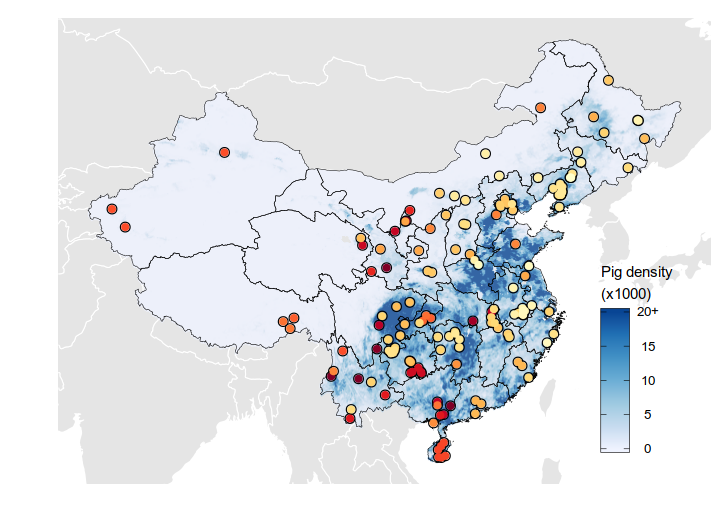

In [65]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
remove_axes = theme(axis.text = element_blank(),axis.line = element_blank(),axis.ticks = element_blank(),
                    panel.border = element_blank(),panel.grid = element_blank(),axis.title = element_blank())

chn0 <- raster::getData("GADM", country = "CHN", level = 0)
map <- chn1f # Fortified admin 1 map
pd <- "../../data/2010pigsdistribution/5_Pg_2010_Da.tif"
pd <- raster::raster(pd)
pd2 <- crop(pd, chn0)
load("../Natalie/chn0_pd2.RData")

thr=20000
values(pd2)[values(pd2) >= thr] = thr

polymask <- mask(pd2, chn0_pd2)

brks_Pigs = c(0,5000,10000,15000,20000)
brks_Pigs_lbls = c(0,5,10,15,"20+")
p2 <- chn1f %>% 
    ggplot() +
        geom_sf(data = world, size=.3, color="white") +
        ggspatial::layer_spatial(polymask, interpolate = T, alpha=.8) +
        #scale_fill_viridis(option = "magma", direction = -1, na.value = NA, name="Pig density (x1000)",
        scale_fill_gradientn(colors = brewer.pal(7,"Blues"), na.value = NA, name="Pig density\n(x1000)",
                              guide = guide_colourbar(title.position = "top", direction = "vertical",
                                                      frame.colour = "black", ticks.colour = "black",
                              title.theme = element_text(size = 9), 
                              label.theme = element_text(size = 8, hjust = 0.5)),
                              breaks=brks_Pigs, labels=brks_Pigs_lbls) +
        geom_map(map = chn1f, aes(group = group, map_id = id), color = "black", 
               fill = NA, size=.15, linetype="dotted") +
        expand_limits(x = map$long, y = map$lat) +
        coord_sf(xlim = c(chn_long_minmax), ylim = c(chn_lat_minmax)) +
        theme(legend.position = c(0.89, .27)) 

brks = as.Date(c('20180901','20181201','20190301','20190601','20190901','20191201'),"%Y%m%d")
brks_max = as.Date('20191201',"%Y%m%d")
brks_min = as.Date('20180801',"%Y%m%d")
brks_lbls = c('Sep 2018','Dec 2018','Mar 2019','Jun 2019','Sep 2019','Dec 2019')

p2 = p2 +         
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat), color='black', size=2.4, shape=21) +
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat, color = start), size=1.6) +
    scale_color_gradientn(colors = c(brewer.pal(9,"YlOrRd"),rep(brewer.pal(9,"YlOrRd")[9],2)),
                          breaks = brks,
                          labels = brks_lbls,
                          limits = c(brks_min, max(c(max(df$start), brks_max))), 
                          name = "Outbreak start date", 
                          trans = "date", 
                          guide = F) +
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

ggsave(plot=p2,width=cs[1],height=cs[2],filename="../../figures/draft/Fig1-map2.pdf",useDingbats=FALSE)

p2

Joining, by = "id"


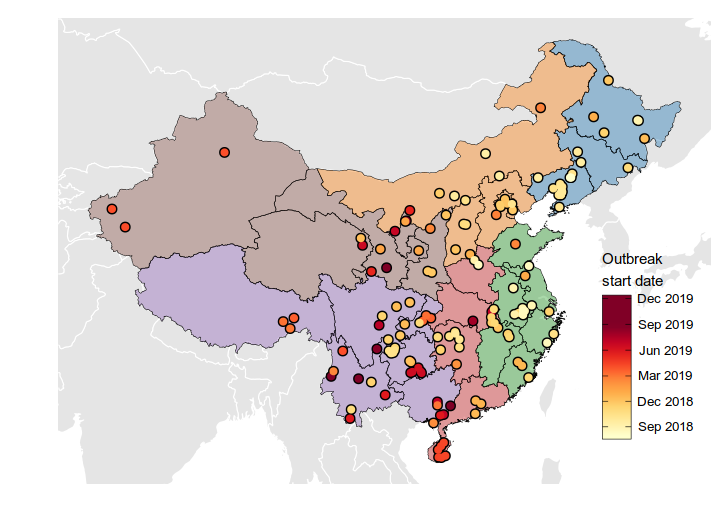

In [33]:
chn1f -> chn_map

df_regions_id <- df_regions
names(df_regions_id) <- c("region", "id")
#chn1 %>% fortify -> chn_map
#df %<>% left_join(df_regions)

cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

p1 = ggplot() +
        geom_sf(data = world, size=.3, color="white") +
        geom_map(map=chn1f, data=left_join(chn1f,df_regions_id), 
                 aes(fill=region, map_id=id), color = "black", alpha=.4,
                 size=.15) +
        guides(fill = F) +
        coord_sf(xlim = c(73.5577, 134.7739), ylim = c(18.15931, 53.56086), expand = TRUE) +
        scale_fill_manual(values = myColors)  +
        theme(legend.justification = c(1, 1), legend.position = c(4, .57), legend.direction='horizontal')

brks = as.Date(c('20180901','20181201','20190301','20190601','20190901','20191201'),"%Y%m%d")
brks_max = as.Date('20191201',"%Y%m%d")
brks_min = as.Date('20180801',"%Y%m%d")
brks_lbls = c('Sep 2018','Dec 2018','Mar 2019','Jun 2019','Sep 2019','Dec 2019')

p1 = p1 +         
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat), color='black', size=2.4) +
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat, color = start),size=1.6) +
    scale_color_gradientn(colors = c(brewer.pal(9,"YlOrRd"),rep(brewer.pal(9,"YlOrRd")[9],2)),
                          breaks = brks,
                          labels = brks_lbls,
                          limits = c(brks_min, max(c(max(df$start), brks_max))), 
                          name = "Outbreak\nstart date", 
                          trans = "date", 
                          guide = guide_colourbar(title.position='top',direction = "vertical",
                                                  frame.colour = "black", ticks.colour = "black",
                                                  title.theme = element_text(size = 9),
                                                  label.theme = element_text(size = 8, hjust = 0.5))) +
    theme(legend.position = c(.985, .52)) + 
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

ggsave(plot=p1,width=cs[1],height=cs[2],filename="../../figures/draft/Fig1-map1.pdf",useDingbats=FALSE)

p1

# Looking at more fine administrative division of China

In [34]:
chn2 = raster::getData("GADM", country = "CHN", level = 2)
save(chn2, file="chn2.Rda")
chn2f = fortify(chn2,region="NAME_2")
save(chn2f, file="chn2f.Rda")

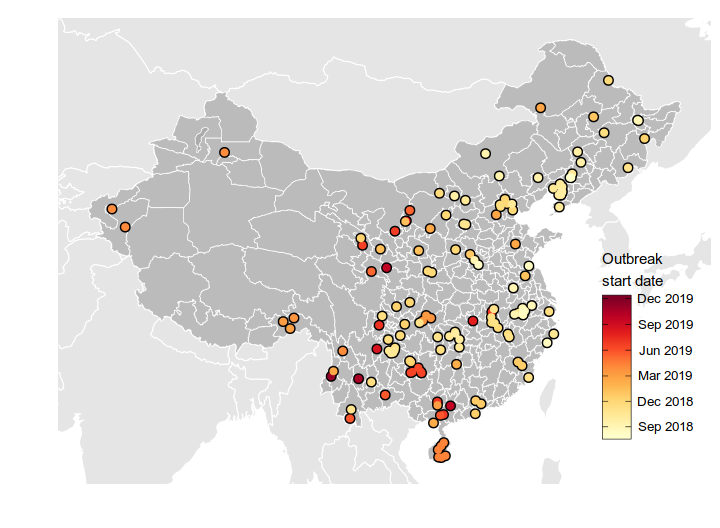

In [35]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

p1 = ggplot() +
        geom_sf(data = world, size=.3, color="white") +
        geom_map(map=chn2f, data=chn2f, aes(map_id=id), fill="darkgrey", alpha=.7, color = "white", size=.2) +
        guides(fill = F) +
        coord_sf(xlim = c(73.5577, 134.7739), ylim = c(18.15931, 53.56086), expand = TRUE) +
        theme(legend.justification = c(1, 1), legend.position = c(4, .57), legend.direction='horizontal')

p1 = p1 +         
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat), color='black', size=2.4) +
    geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat, color = start),size=1.6) +
    scale_color_gradientn(colors = brewer.pal(9,"YlOrRd"),
                          breaks = brks,
                          labels = brks_lbls,
                          limits = c(brks_min, max(c(max(df$start), brks_max))), 
                          name = "Outbreak\nstart date", 
                          trans = "date", 
                          guide = guide_colourbar(title.position='top',direction = "vertical",
                                                  frame.colour = "black", ticks.colour = "black",
                                                  title.theme = element_text(size = 9),
                                                  label.theme = element_text(size = 8, hjust = 0.5))) +
    theme(legend.position = c(.985, .52)) + 
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

p1

In [36]:
outbreak_coords = st_as_sf(df, coords = c("long","lat"), crs = st_crs(chn2))
df_chn2 = st_as_sf(chn2)
df_chn2_combined = st_join(outbreak_coords,df_chn2)
df_chn2_combined %<>% dplyr::select(NAME_2,id) %>% right_join(df,by="id") %>% rename(`county`=`NAME_2`) -> df_combined
st_geometry(df_combined) <- NULL
df_combined %>% head

although coordinates are longitude/latitude, st_intersects assumes that they are planar
although coordinates are longitude/latitude, st_intersects assumes that they are planar


county,id,No,report_info,order,date_submission,date_confirmation,province,location,lat,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<chr>,<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
Shenyang,1,67,other report,1,2018-08-03,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Shenbei Street,42.0225,⋯,2018-10-01,Swine,19420,47,47,19373,0,2018,31,2018-08
Shenyang,2,67,other report,5,2018-09-07,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Yinjia village,42.0200,⋯,2018-12-04,Swine,140,1,0,140,0,2018,32,2018-08
Shenyang,3,67,other report,4,2018-09-07,2018-08-03,Liaoning,Shenyang_Shenbei New District_Farm_Cailuo yi village,42.0200,⋯,2018-12-04,Swine,216,2,0,216,0,2018,32,2018-08
Zhengzhou,4,69,other report,1,2018-08-16,2018-08-16,Henan,Zhengzhou_Slaughterhouse_Economic Development_Zone,34.7240,⋯,2018-10-01,Swine,1806,30,30,1776,0,2018,33,2018-08
Lianyungang,5,70,other report,1,2018-08-19,2018-08-19,Jiangsu,Lianyungang_Haizhou District_Farm_Baofu Village,34.6280,⋯,2018-10-04,Swine,14686,615,88,14598,0,2018,33,2018-08
Wenzhou,6,71,other report,1,2018-08-23,2018-08-22,Zhejiang,Wenzhou_Yueqing_Farm_Zhang ao Village,28.2000,⋯,2018-10-10,Swine,1864,430,340,1524,0,2018,33,2018-08


In [37]:
# Checking if there were some NAs
df_combined %>% filter(is.na(county))

county,id,No,report_info,order,date_submission,date_confirmation,province,location,lat,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<chr>,<int>,<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
NA,46,67,other report,22,2018-10-18,2018-08-03,Liaoning,Panjin_Dawa District_Backyard_Hanjia Village Xian_Township,40.5655,⋯,2018-12-03,Swine,161,43,43,118,0,2018,42,2018-10


In [38]:
# we assign it almost manually
df_combined %<>% mutate(county = if_else(((is.na(county)) & stringr::str_detect(location,"Panjin")),"Panjin",county))

In [39]:
df_number_of_outbreaks = df_combined  %>% group_by(county,province) %>% summarize(outbreaks = n())
df_number_of_outbreaks %>% arrange(-outbreaks) %>% head

county,province,outbreaks
<chr>,<chr>,<int>
Tieling,Liaoning,10
Qiannan Buyei and Miao,Guizhou,6
Hainan,Hainan,5
Anshan,Liaoning,4
Beijing,Beijing,4
Huanggang,Hubei,4


In [40]:
df_number_of_outbreaks %>% filter(stringr::str_detect(province, 'Mongol'))

county,province,outbreaks
<chr>,<chr>,<int>
Chongqing,Nei Mongol,1
Shizuishan,Nei Mongol,1
Xilin Gol,Nei Mongol,1
Yinchuan,Nei Mongol,1


In [41]:
df_number_of_outbreaks$outbreaks %>% sum

[1] 153

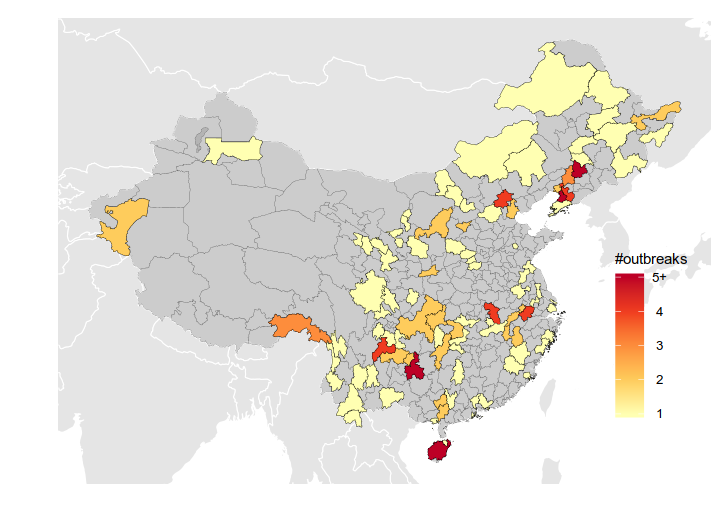

In [42]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

ymax = 5
p1 = ggplot() +
        geom_sf(data = world, size=.3, color="white") +
        geom_map(map=chn2f, data=chn2f, aes(map_id=id), fill="darkgrey", alpha=.4, color = "black", size=.03) +
        geom_map(map=chn2f, 
                 data=right_join(chn2f,
                                 df_number_of_outbreaks %>% rename(id=county) %>% mutate(outbreaks = ifelse(outbreaks>ymax,ymax,outbreaks)), 
                                 by="id"), 
                 aes(map_id=id,fill=outbreaks),
                 alpha=1, color = "black", size=.1) +
        coord_sf(xlim = c(73.5577, 134.7739), ylim = c(18.15931, 53.56086), expand = TRUE) +
        theme(legend.justification = c(1, 1), legend.position = c(4, .57), legend.direction='horizontal') +
#     geom_point(data = arrange(df,desc(start)), aes(x = long, y = lat), color='black', size=.4, alpha=.2) +
    scale_fill_gradientn(colors = brewer.pal(5,"YlOrRd"),
                          name = "#outbreaks",
                          breaks = 1:ymax,
                          labels = c(1:(ymax-1),paste0(ymax,"+")),
                          guide = guide_colourbar(title.position='top',direction = "vertical",
                                                  title.theme = element_text(size = 9),
                                                  label.theme = element_text(size = 8, hjust = 0.5))) +
    theme(legend.position = c(.985, .52)) + 
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

ggsave(plot=p1,width=cs[1],height=cs[2],filename="../../figures/draft/Fig1-map_outbreaks_by_county.pdf",useDingbats=FALSE)

p1

# Projected Chinese population by county

In [ ]:
chn2ocha_ = read_sf(dsn = "../../data/shapefiles/chn_admbnda_adm2_ocha") 
chn2ocha = chn2ocha_ %>% as('Spatial')
chn2ocha

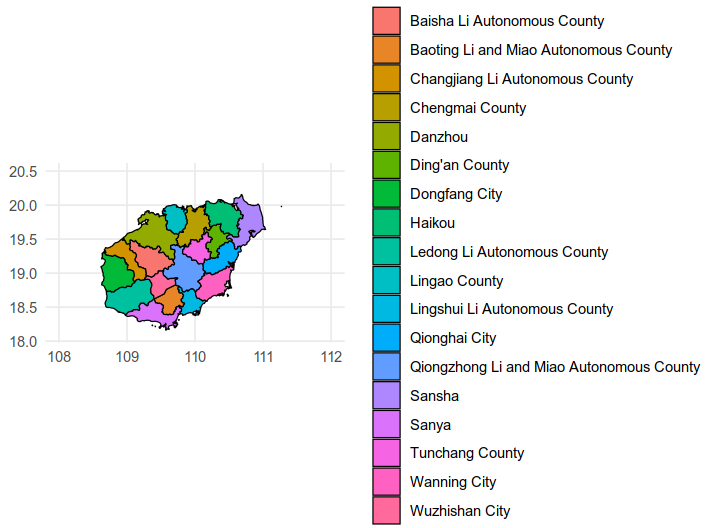

In [44]:
chn2ochaf_Hainan = fortify(chn2ocha[chn2ocha$ADM1_EN=='Hainan Province',],region="ADM2_EN")
ggplot() +
    geom_map(map=chn2ochaf_Hainan, data=chn2ochaf_Hainan, 
         aes(map_id=id,fill=id), color = "black",
         size=.35) +
    coord_sf(xlim = c(108, 112), ylim = c(18.1, 20.5), expand = TRUE)

In [ ]:
# change to TRUE if you to recalculate
# but it takes much time because of high-resolution of the raster
# time to recalculate on a server was 52 minutes for me
recalc = F
if (recalc) {
    ptm = proc.time()
    
    chnpop = "../../../Hokkaido_Data/China/chn_ppp_2019.tif"
    chnpop = raster::raster(chnpop)

#     counties = chn2@data$NAME_2
#     counties_chn = chn2@data$NL_NAME_2
#     provinces = chn2@data$NAME_1
#     provinces_chn = chn2@data$NL_NAME_1
    counties = chn2ocha$ADM2_EN
    counties_chn = chn2ocha$ADM2_ZH
    provinces = chn2ocha$ADM1_EN
    provinces_chn = chn2ocha$ADM1_ZH
    
    # creating cluster
    number_of_cores = parallel::detectCores()
    clusters = parallel::makeCluster(number_of_cores)
    registerDoParallel(clusters)
    
    # paralized for-loop
    foreach(i=1:length(counties), 
        .combine=rbind,
        .packages='raster',
        .inorder=FALSE) %dopar% 
    {
        county = counties[i]
        province = provinces[i]
        county_chn = counties_chn[i]
        province_chn = provinces_chn[i]
#         countypoly = chn2[(chn2@data$NAME_2==county)&(chn2@data$NAME_1==province),]
        countypoly = chn2ocha[(chn2ocha@data$ADM2_EN==county)&(chn2ocha@data$ADM1_EN==province),]
        cr = crop(chnpop, countypoly, snap="out")                    
        fr = rasterize(countypoly, cr)   
        lr = mask(x=cr,mask=fr)
        data.frame(county=county,county_chn=county_chn,
                   province=province,province_chn=province_chn,
                   pop=cellStats(lr,sum))
    } -> countypop
   
    # shutting down the cluster
    stopCluster(clusters)
    
    countypop %<>% mutate_if(is.factor, as.character)
    countypop[countypop$county=='Sansha',]$county_chn = '文昌'
    countypop[countypop$county=='Sansha',]$county = 'Wenchang'
    
    save(countypop, file="chncountypop.Rda")
    
    ((proc.time()-ptm))
} else {
    load(file="chncountypop.Rda")
    countypop %<>% mutate_if(is.factor, as.character)
}
countypop %>% head

In [ ]:
fitted_models = dict([(model_high_ghs.name, traces_high_ghs),
                      (model_high_ghs_overdisp.name, traces_high_ghs_overdisp)])
df_comp_WAIC = pm.compare(fitted_models)
pm.compareplot(df_comp_WAIC);
df_comp_WAIC

In [54]:
countypop %>% summarize(sum(pop))

sum(pop)
<dbl>
1413962034


In [55]:
countypop %>% nrow

[1] 361

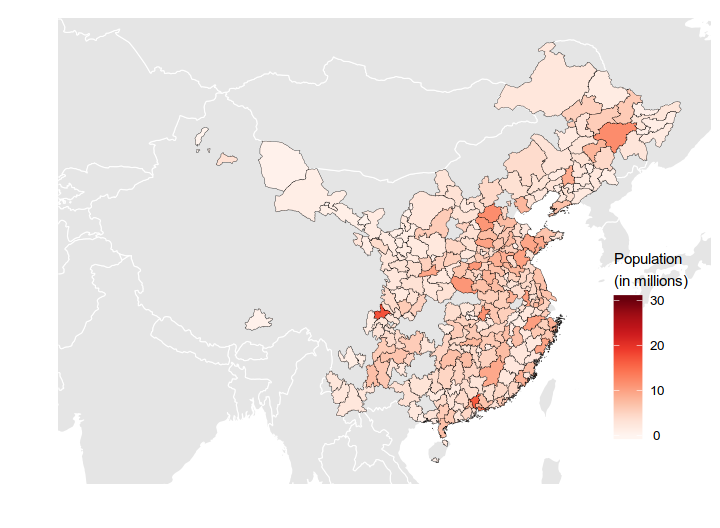

In [56]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

ymax = 5
p1 = ggplot() +
        geom_sf(data = world, size=.3, color="white") +
#         geom_map(map=chn2f, data=chn2f, aes(map_id=id), fill="darkgrey", alpha=.4, color = "black", size=.03) +
        geom_map(map=chn2f, 
                 data=right_join(chn2f,countypop %>% rename(id=county),by="id"), 
                 aes(map_id=id,fill=pop),
                 alpha=1, color = "black", size=.1) +
        coord_sf(xlim = c(73.5577, 134.7739), ylim = c(18.15931, 53.56086), expand = TRUE) +
        theme(legend.justification = c(1, 1), legend.position = c(4, .57), legend.direction='horizontal') +
    theme(legend.position = c(.985, .52)) + 
    scale_fill_gradientn(colors = brewer.pal(9,"Reds"),
                          name = "Population\n(in millions)",
                          breaks = c(0,1,2,3)*1e7,
                          labels = c(0,10,20,30),
                          limits = c(0,max(countypop$pop)),
                          guide = guide_colourbar(title.position='top',direction = "vertical",
                                                  title.theme = element_text(size = 9),
                                                  label.theme = element_text(size = 8, hjust = 0.5))) +
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

ggsave(plot=p1,width=cs[1],height=cs[2],filename="../../figures/draft/Fig1-map_population_by_county.pdf",useDingbats=FALSE)

p1

# Pig density by county

In [57]:
# time to recalc was 19 seconds
recalc = F
if (recalc) {
    ptm = proc.time()
    
    pd = "../../data/2010pigsdistribution/5_Pg_2010_Da.tif"
    pd = raster::raster(pd)

    counties = chn2@data$NAME_2
    provinces = chn2@data$NAME_1
    
    # creating cluster
    number_of_cores = parallel::detectCores()-2
    clusters = parallel::makeCluster(number_of_cores)
    registerDoParallel(clusters)
    
    # paralized for-loop
    foreach(i=1:length(counties), 
        .combine=rbind,
        .packages='raster',
        .inorder=FALSE) %dopar% 
    {
        county = counties[i]
        province = provinces[i]
        countypoly = chn2[(chn2@data$NAME_2==county)&(chn2@data$NAME_1==province),]
        cr = crop(pd, countypoly, snap="out")                    
        fr = rasterize(countypoly, cr)   
        lr = mask(x=cr,mask=fr)
        data.frame(county=county,province=province,hogs=cellStats(lr,sum))
    } -> countyhogs
   
    # shutting down the cluster
    stopCluster(clusters)
    
    save(countyhogs, file="chncountyhogs.Rda")
    
    ((proc.time()-ptm))
} else {
    load(file="chncountyhogs.Rda")
}
countyhogs %>% head

county,province,hogs
<fct>,<fct>,<dbl>
Anqing,Anhui,2247762.9
Bengbu,Anhui,646450.5
Bozhou,Anhui,1865421.0
Chaohu,Anhui,660837.1
Chizhou,Anhui,632746.0
Chuzhou,Anhui,2015893.8


In [58]:
countyhogs %>% summarize(sum(hogs))

sum(hogs)
<dbl>
469856780


Warning message:
“Column `id` joining character vector and factor, coercing into character vector”

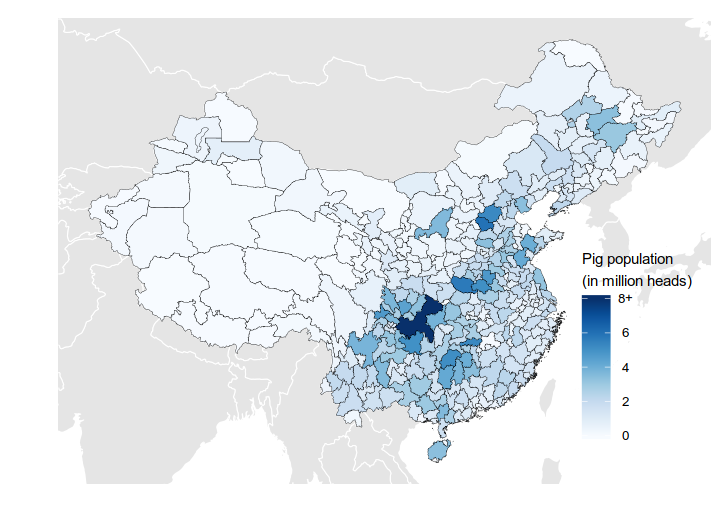

In [59]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

thr=8000000

ymax = 5
p1 = ggplot() +
        geom_sf(data = world, size=.3, color="white") +
#         geom_map(map=chn2f, data=chn2f, aes(map_id=id), fill="darkgrey", alpha=.4, color = "black", size=.03) +
        geom_map(map=chn2f, 
                 data=right_join(chn2f,countyhogs %>% rename(id=county) %>% mutate(hogs = if_else(hogs>=thr,thr,hogs)),by="id"), 
                 aes(map_id=id,fill=hogs),
                 alpha=1, color = "black", size=.1) +
        coord_sf(xlim = c(73.5577, 134.7739), ylim = c(18.15931, 53.56086), expand = TRUE) +
        theme(legend.justification = c(1, 1), legend.position = c(4, .57), legend.direction='horizontal') +
    theme(legend.position = c(.995, .52)) + 
    scale_fill_gradientn(colors = brewer.pal(9,"Blues"),
                          breaks = c(0,2,4,6,8)*1e6,
                          labels = c(0,2,4,6,"8+"),
                          limits = c(0,8)*1e6,
                          name = "Pig population\n(in million heads)",
                          guide = guide_colourbar(title.position='top',direction = "vertical",
                                                  title.theme = element_text(size = 9),
                                                  label.theme = element_text(size = 8, hjust = 0.5))) +
    remove_axes +
    theme(panel.grid.major = element_line(color = "white"), axis.text = element_text(color = "white"))

ggsave(plot=p1,width=cs[1],height=cs[2],filename="../../figures/draft/Fig1-map_pigdensity_by_county.pdf",useDingbats=FALSE)

p1

# Saving data

In [60]:
# first, data about outbreaks that includes the county name
df_combined %>%
    dplyr::select(id,date_submission,date_confirmation,province,county,everything()) %T>%
    data.table::fwrite('../../data/by_county/outbreaks.csv') %>%
    head

id,date_submission,date_confirmation,province,county,No,report_info,order,location,lat,⋯,end,species,susceptible,cases,deaths,destroyed,slaughtered,isoyr,isowk,yearmonth
<int>,<date>,<date>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,⋯,<date>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,2018-08-03,2018-08-03,Liaoning,Shenyang,67,other report,1,Shenyang_Shenbei New District_Farm_Shenbei Street,42.0225,⋯,2018-10-01,Swine,19420,47,47,19373,0,2018,31,2018-08
2,2018-09-07,2018-08-03,Liaoning,Shenyang,67,other report,5,Shenyang_Shenbei New District_Farm_Yinjia village,42.0200,⋯,2018-12-04,Swine,140,1,0,140,0,2018,32,2018-08
3,2018-09-07,2018-08-03,Liaoning,Shenyang,67,other report,4,Shenyang_Shenbei New District_Farm_Cailuo yi village,42.0200,⋯,2018-12-04,Swine,216,2,0,216,0,2018,32,2018-08
4,2018-08-16,2018-08-16,Henan,Zhengzhou,69,other report,1,Zhengzhou_Slaughterhouse_Economic Development_Zone,34.7240,⋯,2018-10-01,Swine,1806,30,30,1776,0,2018,33,2018-08
5,2018-08-19,2018-08-19,Jiangsu,Lianyungang,70,other report,1,Lianyungang_Haizhou District_Farm_Baofu Village,34.6280,⋯,2018-10-04,Swine,14686,615,88,14598,0,2018,33,2018-08
6,2018-08-23,2018-08-22,Zhejiang,Wenzhou,71,other report,1,Wenzhou_Yueqing_Farm_Zhang ao Village,28.2000,⋯,2018-10-10,Swine,1864,430,340,1524,0,2018,33,2018-08


In [ ]:
# now working on pop sizes
left_join(countyhogs,countypop,by=c("county","province")) %>% mutate_each(list(~round(.)),-county,-province) -> geopop_df 
((geopop_df %>% nrow))
geopop_df %>% head

In [ ]:
# area by county ids
# we transform first to meters and relevant geoprojection (see https://epsg.io/32651)
chn2 %>% spTransform("+proj=utm +zone=51 ellps=WGS84") -> chn2_
data.frame(county=chn2_@data$NAME_2, province=chn2_@data$NAME_1,
           area=sapply(chn2_@polygons, function(x) x@Polygons[[1]]@area),
           stringsAsFactors=F) %>%
    mutate(area = area/1e6) %>% # to kmq
    mutate_each(list(~round(.,3)),-county,-province) -> df_geo_by_county
# location of the centroid
data.frame(county=chn2@data$NAME_2, province=chn2@data$NAME_1,
           long=sapply(chn2@polygons, function(x) x@Polygons[[1]]@labpt[1]),
           lat=sapply(chn2@polygons, function(x) x@Polygons[[1]]@labpt[2]),
           stringsAsFactors=F) %>%
    left_join(df_geo_by_county,by = c("county", "province")) -> df_geo_by_county
                       

    
df_geo_by_county %>% head

In [ ]:
# calculate coordinates of the centroid
df_geo_by_county %>% 
    left_join(geopop_df,by=c('county','province')) -> df_geo_by_county_

((df_geo_by_county_ %>% nrow))

df_geo_by_county_ %>%
    # drop duplicates (dplyr problem)
    dplyr::select(county,province,pop,hogs,everything()) %T>%
    data.table::fwrite('../../data/by_county/geopop.csv') %>%
    head(30)

df_geo_by_county = df_geo_by_county_

# Correlation between pig population and human population per county

In [ ]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

df_geo_by_county %>% ggplot() +
    geom_point(aes(x=hogs,y=pop)) +
    coord_cartesian(xlim=c(1e3,20e6),ylim=c(1e3,35e6))

In [ ]:
lm(pop ~ 0+hogs,df_geo_by_county)

In [ ]:
cor.test(df_geo_by_county$hogs, df_geo_by_county$pop, method = "pearson")

In [ ]:
cs = c(6,4.4)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

df_geo_by_county %>% ggplot() +
    geom_point(aes(x=hogs,y=pop)) +
    scale_x_log10() + scale_y_log10() +
    coord_cartesian(xlim=c(1e3,40e6),ylim=c(1e3,40e6))

In [54]:
lm(log10(pop) ~ log10(hogs),df_geo_by_county)


Call:
lm(formula = log10(pop) ~ log10(hogs), data = df_geo_by_county)

Coefficients:
(Intercept)  log10(hogs)  
     3.7788       0.4605  


In [55]:
cor.test(log10(df_geo_by_county$hogs), log10(df_geo_by_county$pop), method = "pearson")


	Pearson's product-moment correlation

data:  log10(df_geo_by_county$hogs) and log10(df_geo_by_county$pop)
t = 20.947, df = 342, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6993358 0.7925587
sample estimates:
     cor 
0.749642 
